In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from scipy.constants import mu_0

from desc.backend import jit
from desc.io import load
from desc.grid import LinearGrid, Grid
from desc.magnetic_fields import FourierCurrentPotentialField
from desc.optimize import Optimizer
from desc.objectives import (
    BoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixParameters,
    ObjectiveFunction
)

from nufft_biot.embedding import make_optimal_box, embed_geometry_in_box
from nufft_biot.field import compute_B_hat, eval_B
try:
    from nufft_biot.desc_interface import desc_volume_current, desc_surface_current
except ImportError:
    raise ImportError("Could not import 'desc_interface.py'.")

jax.config.update("jax_enable_x64", True)

In [6]:
def filter_nans(name, X, Y, Z, Jx, Jy, Jz, w):
    mask = (
        jnp.isfinite(X) & jnp.isfinite(Y) & jnp.isfinite(Z) &
        jnp.isfinite(Jx) & jnp.isfinite(Jy) & jnp.isfinite(Jz) &
        jnp.isfinite(w)
    )
    n_total = len(X)
    n_valid = jnp.sum(mask)
    if n_valid < n_total:
        print(f"    ACTION: Filtering {n_total - n_valid} NaN points from {name}...")
        return X[mask], Y[mask], Z[mask], Jx[mask], Jy[mask], Jz[mask], w[mask]
    return X, Y, Z, Jx, Jy, Jz, w

@jax.jit
def biot_savart_direct(
    target_points,
    source_X, source_Y, source_Z,
    Jx, Jy, Jz,
    w,
):
    mu0 = 4.0 * jnp.pi * 1e-7
    source_points = jnp.stack([source_X, source_Y, source_Z], axis=1)
    J_source = jnp.stack([Jx, Jy, Jz], axis=1)
    epsilon = 1e-10

    def compute_single_point(r_target):
        r_vec = r_target - source_points
        dist_sq = jnp.sum(r_vec**2, axis=1)
        dist_soft = jnp.sqrt(dist_sq + epsilon**2)
        factor = w / (dist_soft**3)
        
        cross_x = J_source[:, 1] * r_vec[:, 2] - J_source[:, 2] * r_vec[:, 1]
        cross_y = J_source[:, 2] * r_vec[:, 0] - J_source[:, 0] * r_vec[:, 2]
        cross_z = J_source[:, 0] * r_vec[:, 1] - J_source[:, 1] * r_vec[:, 0]
        
        Bx = (mu0 / (4.0 * jnp.pi)) * jnp.sum(cross_x * factor)
        By = (mu0 / (4.0 * jnp.pi)) * jnp.sum(cross_y * factor)
        Bz = (mu0 / (4.0 * jnp.pi)) * jnp.sum(cross_z * factor)
        return jnp.array([Bx, By, Bz])

    return jax.vmap(compute_single_point)(target_points)

In [3]:
filename = "GS_SOLOVEV_DESC_output.h5"
if os.path.exists(filename):
    load_path = filename
else:
    script_dir = os.path.dirname(os.path.abspath(__file__))
    possible_path = os.path.join(script_dir, filename)
    if os.path.exists(possible_path):
        load_path = possible_path
    else:
        print(f"Error: Could not find '{filename}'")
        

print(f"Loading equilibrium from: {load_path}")
eq = load(load_path)

print("\n--- Optimization Step ---")
offset_surf = eq.surface.constant_offset_surface(offset=0.5)

G_coeff = eq.compute("G")["G"][-1]
G_required = -(G_coeff / mu_0 * 2 * np.pi)

print(f"    Eq 'G' Coefficient: {G_coeff:.4e} T*m")

field = FourierCurrentPotentialField.from_surface(
    offset_surf, 
    M_Phi=24, N_Phi=0, 
    G=G_required
)

R_modes = eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > 0, :]
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > 0, :]

bdry_constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
)
constraints = (
    FixParameters(eq),
    FixParameters(field, {"R_lmn": True, "Z_lmn": True, "G": True}),
)
objective = ObjectiveFunction((BoundaryError(eq, field, field_grid=LinearGrid(M=40, NFP=50))))
optimizer = Optimizer("lsq-exact")

(eq, field_opt), out = optimizer.optimize(
    [eq, field], objective, constraints + bdry_constraints,
    verbose=1, options={}, copy=True, ftol=0, xtol=0, maxiter=50
)

Loading equilibrium from: GS_SOLOVEV_DESC_output.h5


/Users/lee/Documents/nufft_biot/.venv/lib/python3.13/site-packages/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_rho' was not loaded from the file.
This is likely because the file containing 'FourierRZToroidalSurface' was created before '_rho' became an attribute of objects of class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'.
The user may verify that a default value has been set.
This warning will persist until the file is saved with the new object.

Note to developers: Add 'def _set_up(self)' as a method to class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'
(or the superclass where this new attribute is assigned) that assigns a value to '_rho'.
This method is called automatically when a file is loaded.
Recall that the testing suite will fail on warnings.
  warnings.warn(



--- Optimization Step ---
    Eq 'G' Coefficient: 2.1935e+00 T*m
Building objective: Boundary error
Precomputing transforms
Building objective: fixed parameters
Building objective: fixed parameters
Building objective: lcfs R
Building objective: lcfs Z
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency


/Users/lee/Documents/nufft_biot/.venv/lib/python3.13/site-packages/desc/objectives/utils.py:481: RuntimeWarning: divide by zero encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],
/Users/lee/Documents/nufft_biot/.venv/lib/python3.13/site-packages/desc/objectives/utils.py:481: RuntimeWarning: overflow encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],
/Users/lee/Documents/nufft_biot/.venv/lib/python3.13/site-packages/desc/objectives/utils.py:481: RuntimeWarning: invalid value encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],


Number of parameters: 25
Number of objectives: 146

Starting optimization
Using method: lsq-exact
`gtol` condition satisfied. (gtol=1.00e-08)
         Current function value: 3.742e-05
         Total delta_x: 3.502e+07
         Iterations: 7
         Function evaluations: 8
         Jacobian evaluations: 8
                                                                 Start  -->   End
Total (sum of squares):                                      1.553e+00  -->   3.742e-05, 
Maximum absolute Boundary normal field error:                9.552e-01  -->   7.229e-03 (T*m^2)
Minimum absolute Boundary normal field error:                2.321e-15  -->   5.018e-15 (T*m^2)
Average absolute Boundary normal field error:                5.081e-01  -->   3.073e-03 (T*m^2)
Maximum absolute Boundary normal field error:                2.474e-01  -->   1.873e-03 (normalized)
Minimum absolute Boundary normal field error:                6.013e-16  -->   1.300e-15 (normalized)
Average absolute Boundary norm

In [ ]:
from jax_finufft import nufft1, nufft2
import jax.numpy as jnp


def compute_and_eval_J(
    X, Y, Z,          
    Jx, Jy, Jz,      
    w,               
    target_pos,      
    box,
):

    Nx, Ny, Nz = box.Nx, box.Ny, box.Nz
    shape = (Nx, Ny, Nz)
    cx = (Jx * w).astype(jnp.complex128)
    cy = (Jy * w).astype(jnp.complex128)
    cz = (Jz * w).astype(jnp.complex128)

    tx = 2.0 * jnp.pi * X / box.Lx
    ty = 2.0 * jnp.pi * Y / box.Ly
    tz = 2.0 * jnp.pi * Z / box.Lz
    
    Jx_hat = nufft1(shape, cx, tx, ty, tz, iflag=-1, eps=1e-12)
    Jy_hat = nufft1(shape, cy, tx, ty, tz, iflag=-1, eps=1e-12)
    Jz_hat = nufft1(shape, cz, tx, ty, tz, iflag=-1, eps=1e-12)
    
    KX, KY, KZ = box.KX, box.KY, box.KZ
    K2 = KX**2 + KY**2 + KZ**2
    mask = K2 > 0.0
    K2_safe = jnp.where(mask, K2, 1.0)

    k_dot_J = KX * Jx_hat + KY * Jy_hat + KZ * Jz_hat

    Jx_hat = jnp.where(mask, Jx_hat - KX * k_dot_J / K2_safe, 0.0)
    Jy_hat = jnp.where(mask, Jy_hat - KY * k_dot_J / K2_safe, 0.0)
    Jz_hat = jnp.where(mask, Jz_hat - KZ * k_dot_J / K2_safe, 0.0)

    R_cut = min(box.Lx, box.Ly, box.Lz) / 2.0
    trunc = 1.0 - jnp.cos(jnp.sqrt(K2) * R_cut)

    Jx_hat = jnp.where(mask, Jx_hat * trunc, 0.0)
    Jy_hat = jnp.where(mask, Jy_hat * trunc, 0.0) 
    Jz_hat = jnp.where(mask, Jz_hat * trunc, 0.0)

    Jx_hat /= box.V
    Jy_hat /= box.V
    Jz_hat /= box.V

    tx = 2.0 * jnp.pi * target_pos[:, 0] / box.Lx
    ty = 2.0 * jnp.pi * target_pos[:, 1] / box.Ly
    tz = 2.0 * jnp.pi * target_pos[:, 2] / box.Lz

    Jx_eval = nufft2(Jx_hat, tx, ty, tz, iflag=1, eps=1e-12).real  
    Jy_eval = nufft2(Jy_hat, tx, ty, tz, iflag=1, eps=1e-12).real
    Jz_eval = nufft2(Jz_hat, tx, ty, tz, iflag=1, eps=1e-12).real

    return Jx_eval, Jy_eval, Jz_eval

In [ ]:
print("\n--- Current Extraction ---")
X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p = desc_volume_current(eq, L_grid=64, M_grid=64, N_grid=128)

X_s, Y_s, Z_s, Jx_s, Jy_s, Jz_s, w_s = desc_surface_current(
    field_opt, offset_surf, M_grid=240, N_grid=240
)

X_all = jnp.concatenate([X_p, X_s])
Y_all = jnp.concatenate([Y_p, Y_s])
Z_all = jnp.concatenate([Z_p, Z_s])
# box = make_optimal_box(X_all, Y_all, Z_all, n_cells=288, padding=2.0)
box = make_optimal_box(X_p, Y_p, Z_p, n_cells=256, padding=2.0)
    
print("X range:", float(X_all.min()), float(X_all.max())) 
print("Box Lx:", float(box.Lx))


--- Current Extraction ---
Geometry Extent: [9.80, 9.80, 3.16]
Auto-sized Box:  19.59 (cubic)
X range: -5.398843881993401 5.398959038395002
Box Lx: 19.59458344428843


In [ ]:
print("\n--- Computing Fields ---")
Jxp_eval, Jyp_eval, Jzp_eval = compute_and_eval_J(
    X_p, Y_p, Z_p,
    Jx_p, Jy_p, Jz_p,
    w_p,
    target_pos=jnp.stack([X_p, Y_p, Z_p], axis=1),
    box=box,
)

dx = box.Lx / box.Nx
dy = box.Ly / box.Ny
dz = box.Lz / box.Nz
delta_n = jnp.minimum(dx, jnp.minimum(dy, dz)) 

Jx_s_vol = Jx_s / delta_n
Jy_s_vol = Jy_s / delta_n
Jz_s_vol = Jz_s / delta_n
w_s_vol = w_s * delta_n

Jxs_eval, Jys_eval, Jzs_eval = compute_and_eval_J(
    X_s, Y_s, Z_s,
    Jx_s_vol, Jy_s_vol, Jz_s_vol,
    w_s_vol,
    target_pos=jnp.stack([X_s, Y_s, Z_s], axis=1),
    box=box,
)

Kx_recon = delta_n * Jxs_eval
Ky_recon = delta_n * Jys_eval
Kz_recon = delta_n * Jzs_eval

K_int_orig  = jnp.array([jnp.sum(Jx_s * w_s), jnp.sum(Jy_s * w_s), jnp.sum(Jz_s * w_s)])
K_int_recon = jnp.array([jnp.sum(Kx_recon * w_s), jnp.sum(Ky_recon * w_s), jnp.sum(Kz_recon * w_s)])

print("∫K dA (orig) =", K_int_orig)
print("∫K dA (recon)=", K_int_recon)

Jp_mag = jnp.sqrt(Jx_p**2 + Jy_p**2 + Jz_p**2) + 1e-14

rel_err_Jx_p = jnp.abs(Jxp_eval - Jx_p) / Jp_mag
rel_err_Jy_p = jnp.abs(Jyp_eval - Jy_p) / Jp_mag 
rel_err_Jz_p = jnp.abs(Jzp_eval - Jz_p) / Jp_mag

print("\n--- Plasma Current Reconstruction Error ---")
print(f"Max rel error Jx: {jnp.max(rel_err_Jx_p):.3e}")
print(f"Max rel error Jy: {jnp.max(rel_err_Jy_p):.3e}")
print(f"Max rel error Jz: {jnp.max(rel_err_Jz_p):.3e}")

print(f"Mean rel error Jx: {jnp.mean(rel_err_Jx_p):.3e}")
print(f"Mean rel error Jy: {jnp.mean(rel_err_Jy_p):.3e}")
print(f"Mean rel error Jz: {jnp.mean(rel_err_Jz_p):.3e}")

Kxs_eval = delta_n * Jxs_eval
Kys_eval = delta_n * Jys_eval
Kzs_eval = delta_n * Jzs_eval

Ks_mag = jnp.sqrt(Jx_s**2 + Jy_s**2 + Jz_s**2) + 1e-14
rel_err_Kx_s = jnp.abs(Kxs_eval - Jx_s) / Ks_mag
rel_err_Ky_s = jnp.abs(Kys_eval - Jy_s) / Ks_mag 
rel_err_Kz_s = jnp.abs(Kzs_eval - Jz_s) / Ks_mag 

print("\n--- Surface Current Reconstruction Error ---")
print(f"Max rel error Jx: {jnp.max(rel_err_Kx_s):.3e}")
print(f"Max rel error Jy: {jnp.max(rel_err_Ky_s):.3e}")
print(f"Max rel error Jz: {jnp.max(rel_err_Kz_s):.3e}")

print(f"Mean rel error Jx: {jnp.mean(rel_err_Kx_s):.3e}")
print(f"Mean rel error Jy: {jnp.mean(rel_err_Ky_s):.3e}") 
print(f"Mean rel error Jz: {jnp.mean(rel_err_Kz_s):.3e}")  



--- Computing Fields ---
∫K dA (orig) = [-1.86264515e-09  5.21540642e-08 -2.85217538e-09]
∫K dA (recon)= [-5.34930802e+01 -5.34930773e+01  1.29706745e+06]

--- Plasma Current Reconstruction Error ---
Max rel error Jx: 6.065e-01
Max rel error Jy: 6.068e-01
Max rel error Jz: 1.802e-01
Mean rel error Jx: 1.615e-02
Mean rel error Jy: 1.617e-02
Mean rel error Jz: 1.468e-02

--- Surface Current Reconstruction Error ---
Max rel error Jx: 5.042e-01
Max rel error Jy: 5.046e-01
Max rel error Jz: 3.492e-01
Mean rel error Jx: 1.186e-01
Mean rel error Jy: 1.186e-01
Mean rel error Jz: 5.308e-02


In [7]:
print("\n--- Current Extraction ---")
X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p = desc_volume_current(eq, L_grid=64, M_grid=64, N_grid=64)

X_s, Y_s, Z_s, Jx_s, Jy_s, Jz_s, w_s = desc_surface_current(
    field_opt, offset_surf, M_grid=240, N_grid=240
)

box = make_optimal_box(X_p, Y_p, Z_p, n_cells=256, padding=2.0) # start with 32 to 64 to 128 to 256

def make_exterior_ghost_points(
    eq,
    shells,
    n_per_shell=2000,
):
    grid_lcfs = LinearGrid(rho=1.0, M=256, N=1)
    lcfs = eq.compute(["R", "Z"], grid=grid_lcfs)

    R_lcfs = lcfs["R"]
    Z_lcfs = lcfs["Z"]

    R0 = jnp.mean(R_lcfs)
    a  = jnp.max(jnp.sqrt((R_lcfs - R0)**2 + Z_lcfs**2))

    Xg, Yg, Zg = [], [], []

    for rho_min, rho_max in shells:
        rho = np.random.uniform(rho_min, rho_max, n_per_shell)
        theta = np.random.uniform(0, 2*np.pi, n_per_shell)
        zeta  = np.random.uniform(0, 2*np.pi, n_per_shell)

        R = R0 + a * rho * np.cos(theta)
        Z = a * rho * np.sin(theta)
        Y = R * np.sin(zeta)
        X = R * np.cos(zeta)

        Xg.append(X)
        Yg.append(Y)
        Zg.append(Z)

    return (
        jnp.concatenate(Xg),
        jnp.concatenate(Yg),
        jnp.concatenate(Zg),
    )

ghost_shells = [
    (1.02, 1.08),
    (1.10, 1.25),
]

X_ghost, Y_ghost, Z_ghost = make_exterior_ghost_points(
    eq,
    ghost_shells,
    n_per_shell=0,
)

Xb_p, Yb_p, Zb_p, shift = embed_geometry_in_box(X_p, Y_p, Z_p, box) # try without a shift

Xb_g = X_ghost - shift[0]
Yb_g = Y_ghost - shift[1]
Zb_g = Z_ghost - shift[2]

Xb_g = jnp.mod(Xb_g, box.Lx)
Yb_g = jnp.mod(Yb_g, box.Ly)
Zb_g = jnp.mod(Zb_g, box.Lz)

Xb = jnp.concatenate([Xb_p, Xb_g])
Yb = jnp.concatenate([Yb_p, Yb_g])
Zb = jnp.concatenate([Zb_p, Zb_g])

Jx_p_box = jnp.concatenate([Jx_p, jnp.zeros_like(Xb_g)])
Jy_p_box = jnp.concatenate([Jy_p, jnp.zeros_like(Xb_g)])
Jz_p_box = jnp.concatenate([Jz_p, jnp.zeros_like(Xb_g)])
w_p_box  = jnp.concatenate([w_p,  jnp.zeros_like(Xb_g)])


print("\n--- Computing Fields ---")
Bx_hat, By_hat, Bz_hat = compute_B_hat(Xb, Yb, Zb, Jx_p_box, Jy_p_box, Jz_p_box, w_p_box, box)

print("\n--- Running Accuracy Validation ---")

n_scan = 100
theta_scan = np.linspace(0, 2 * np.pi, n_scan)
val_grid = LinearGrid(rho=0.9, theta=theta_scan, zeta=0.0)

print("    Fetching Ground Truth (DESC Eq) on rho=0.9...")

# desc_data = eq.compute(["R", "Z", "B"], grid=val_grid, basis="xyz") # desc_data = eq.compute(["X", "Y", "Z", "B"], grid=val_grid, basis="xyz")
desc_data = eq.compute(["X", "Y", "Z", "B"], grid=val_grid, basis="xyz")

# target_R = desc_data["R"] # target_X = desc_data["X"]
target_X = desc_data["X"]
# target_Z = desc_data["Z"] # target_Y = desc_data["Y"]
target_Y = desc_data["Y"]
target_Z = desc_data["Z"]
# target_Y = np.zeros_like(target_R) # target_Z = desc_data["Z"]

B_desc = desc_data["B"] # using the components directly
mag_desc = np.linalg.norm(B_desc, axis=1)

# targets_local = np.stack([target_R, target_Y, target_Z], axis=1)
targets_local = np.stack([target_X, target_Y, target_Z], axis=1)
targets_box = targets_local - np.array(shift)

print("    Computing B_plasma (NUFFT)...")
bx_n, by_n, bz_n = eval_B(Bx_hat, By_hat, Bz_hat, jnp.array(targets_box), box)
B_p_nufft = np.stack([bx_n, by_n, bz_n], axis=1)

print("    Computing B_coil (Direct Biot-Savart)...")
B_s_direct = biot_savart_direct(jnp.array(targets_local), X_s, Y_s, Z_s, Jx_s, Jy_s, Jz_s, w_s)

B_total_rec = B_p_nufft + B_s_direct
mag_rec = np.linalg.norm(B_total_rec, axis=1)

diff_vec = B_total_rec - B_desc
err_abs = np.linalg.norm(diff_vec, axis=1)
err_rel = err_abs / (mag_desc + 1e-12)

print(f"    Mean |B| (Rec): {np.mean(mag_rec):.4f} T")
print(f"    Mean |B| (Ref): {np.mean(mag_desc):.4f} T")
print(f"    Mean Rel Error: {np.mean(err_rel):.4e}")
print(f"    Max Rel Error:  {np.max(err_rel):.4e}")

Bx_rec, By_rec, Bz_rec = B_total_rec.T
Bx_ref, By_ref, Bz_ref = B_desc.T
rel_err_Bx = np.abs(Bx_rec - Bx_ref) / mag_desc
rel_err_By = np.abs(By_rec - By_ref) / mag_desc
rel_err_Bz = np.abs(Bz_rec - Bz_ref) / mag_desc

print("\n--- Component-wise Error Summary ---")
print(f"Max rel error Bx: {np.max(rel_err_Bx):.3e}")
print(f"Max rel error By: {np.max(rel_err_By):.3e}")
print(f"Max rel error Bz: {np.max(rel_err_Bz):.3e}")

print(f"Mean rel error Bx: {np.mean(rel_err_Bx):.3e}")
print(f"Mean rel error By: {np.mean(rel_err_By):.3e}")
print(f"Mean rel error Bz: {np.mean(rel_err_Bz):.3e}")


--- Current Extraction ---
Geometry Extent: [9.80, 9.80, 3.16]
Auto-sized Box:  19.59 (cubic)

--- Computing Fields ---


E0204 18:07:07.217879 5632555 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft3d1



--- Running Accuracy Validation ---
    Fetching Ground Truth (DESC Eq) on rho=0.9...
    Computing B_plasma (NUFFT)...
    Computing B_coil (Direct Biot-Savart)...
    Mean |B| (Rec): 0.7050 T
    Mean |B| (Ref): 0.7029 T
    Mean Rel Error: 6.3619e-03
    Max Rel Error:  9.8674e-03

--- Component-wise Error Summary ---
Max rel error Bx: 5.041e-03
Max rel error By: 4.780e-03
Max rel error Bz: 8.593e-03
Mean rel error Bx: 1.690e-03
Mean rel error By: 3.496e-03
Mean rel error Bz: 4.827e-03


In [9]:
print("\n--- Current Extraction ---")
X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p = desc_volume_current(eq, L_grid=16, M_grid=16, N_grid=32)

box = make_optimal_box(X_p, Y_p, Z_p, n_cells=256, padding=2.0) # start with 32 to 64 to 128 to 256


--- Current Extraction ---
Geometry Extent: [9.78, 9.79, 3.16]
Auto-sized Box:  19.58 (cubic)


In [11]:
Bx_hat, By_hat, Bz_hat = compute_B_hat(X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p, box)

def wrapper_fxn(X_p):
    Bx_hat, By_hat, Bz_hat= compute_B_hat(X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p, box)
    return Bx_hat.sum().real

grad_fn = jax.grad(wrapper_fxn)
gradient = grad_fn(X_p)

E0204 18:14:57.116221 5632555 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft3d2


In [ ]:
print("\n--- Current Extraction ---")
X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p = desc_volume_current(eq, L_grid=64, M_grid=64, N_grid=128)

X_s, Y_s, Z_s, Jx_s, Jy_s, Jz_s, w_s = desc_surface_current(
    field_opt, offset_surf, M_grid=240, N_grid=240
)

box = make_optimal_box(X_p, Y_p, Z_p, n_cells=256, padding=2.0) # start with 32 to 64 to 128 to 256

print("\n--- Computing Fields ---")
Bx_hat, By_hat, Bz_hat = compute_B_hat(X_p, Y_p, Z_p, Jx_p, Jy_p, Jz_p, w_p, box)


print("\n--- Running Accuracy Validation ---")

n_scan = 100
theta_scan = np.linspace(0, 2 * np.pi, n_scan)
val_grid = LinearGrid(rho=1, theta=theta_scan, zeta=0.0)

print("    Fetching Ground Truth (DESC Eq) on rho=0.9...")

desc_data = eq.compute(["X", "Y", "Z", "B"], grid=val_grid, basis="xyz")

target_X = desc_data["X"]
target_Y = desc_data["Y"]
target_Z = desc_data["Z"]

B_desc = desc_data["B"] 
mag_desc = np.linalg.norm(B_desc, axis=1)

targets_local = np.stack([target_X, target_Y, target_Z], axis=1)
targets_box = targets_local 

print("    Computing B_plasma (NUFFT)...")
bx_n, by_n, bz_n = eval_B(Bx_hat, By_hat, Bz_hat, jnp.array(targets_box), box)
B_p_nufft = np.stack([bx_n, by_n, bz_n], axis=1)

print("    Computing B_coil (Direct Biot-Savart)...")
B_s_direct = biot_savart_direct(jnp.array(targets_local), X_s, Y_s, Z_s, Jx_s, Jy_s, Jz_s, w_s)

B_total_rec = B_p_nufft + B_s_direct
mag_rec = np.linalg.norm(B_total_rec, axis=1)

diff_vec = B_total_rec - B_desc
err_abs = np.linalg.norm(diff_vec, axis=1)
err_rel = err_abs / (mag_desc + 1e-12)

print(f"    Mean |B| (Rec): {np.mean(mag_rec):.4f} T")
print(f"    Mean |B| (Ref): {np.mean(mag_desc):.4f} T")
print(f"    Mean Rel Error: {np.mean(err_rel):.4e}")
print(f"    Max Rel Error:  {np.max(err_rel):.4e}")

Bx_rec, By_rec, Bz_rec = B_total_rec.T
Bx_ref, By_ref, Bz_ref = B_desc.T
rel_err_Bx = np.abs(Bx_rec - Bx_ref) / mag_desc
rel_err_By = np.abs(By_rec - By_ref) / mag_desc
rel_err_Bz = np.abs(Bz_rec - Bz_ref) / mag_desc

print("\n--- Component-wise Error Summary ---")
print(f"Max rel error Bx: {np.max(rel_err_Bx):.3e}")
print(f"Max rel error By: {np.max(rel_err_By):.3e}")
print(f"Max rel error Bz: {np.max(rel_err_Bz):.3e}")

print(f"Mean rel error Bx: {np.mean(rel_err_Bx):.3e}")
print(f"Mean rel error By: {np.mean(rel_err_By):.3e}")
print(f"Mean rel error Bz: {np.mean(rel_err_Bz):.3e}")


--- Current Extraction ---
Geometry Extent: [9.80, 9.80, 3.16]
Auto-sized Box:  19.59 (cubic)

--- Computing Fields ---


E0202 17:53:52.181799 5632555 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft3d1



--- Running Accuracy Validation ---
    Fetching Ground Truth (DESC Eq) on rho=0.9...
    Computing B_plasma (NUFFT)...


E0202 17:53:58.042463 5632555 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft3d2


    Computing B_coil (Direct Biot-Savart)...
    Mean |B| (Rec): 0.7189 T
    Mean |B| (Ref): 0.7182 T
    Mean Rel Error: 6.9117e-03
    Max Rel Error:  1.4861e-02

--- Component-wise Error Summary ---
Max rel error Bx: 1.018e-03
Max rel error By: 4.011e-03
Max rel error Bz: 1.451e-02
Mean rel error Bx: 3.698e-04
Mean rel error By: 3.552e-03
Mean rel error Bz: 5.444e-03


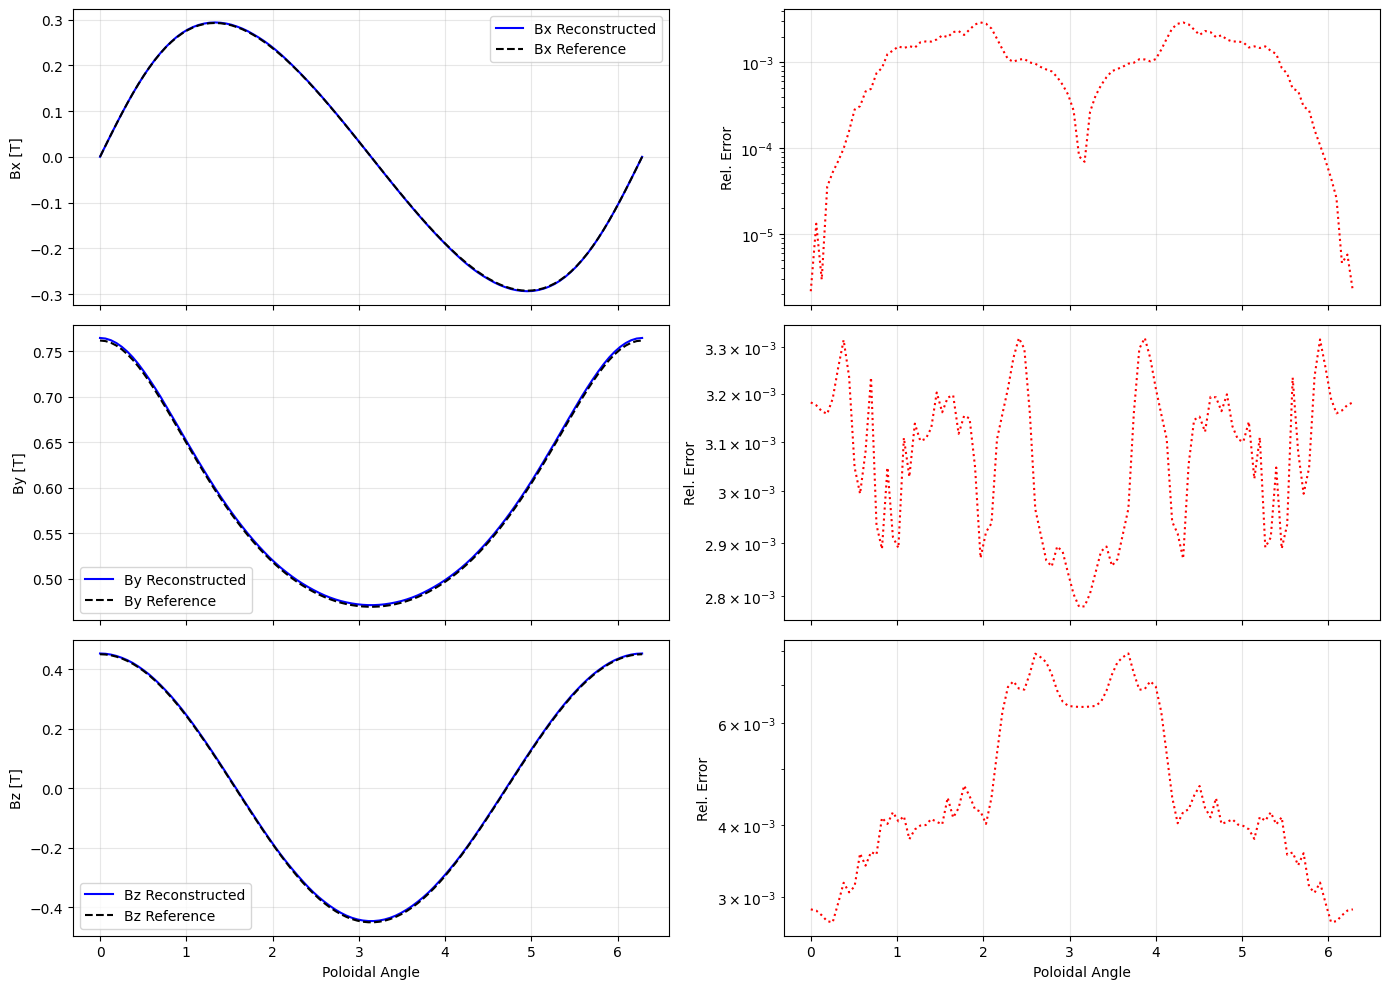

In [ ]:
# Plot 3: Individual Components and Errors
fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)

components = [
    ("Bx", Bx_rec, Bx_ref, rel_err_Bx),
    ("By", By_rec, By_ref, rel_err_By),
    ("Bz", Bz_rec, Bz_ref, rel_err_Bz),
]

for i, (name, B_rec, B_ref, rel_err) in enumerate(components):
    ax = axes[i, 0]
    ax.plot(theta_scan, B_rec, 'b-', label=f"{name} Reconstructed")
    ax.plot(theta_scan, B_ref, 'k--', label=f"{name} Reference")
    ax.set_ylabel(f"{name} [T]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax_err = axes[i, 1]
    ax_err.semilogy(theta_scan, rel_err, 'r:')
    ax_err.set_ylabel("Rel. Error")
    ax_err.grid(True, alpha=0.3)

axes[-1, 0].set_xlabel("Poloidal Angle")
axes[-1, 1].set_xlabel("Poloidal Angle")

plt.tight_layout()
plt.show()

E0130 16:08:52.793506 4914747 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft3d2


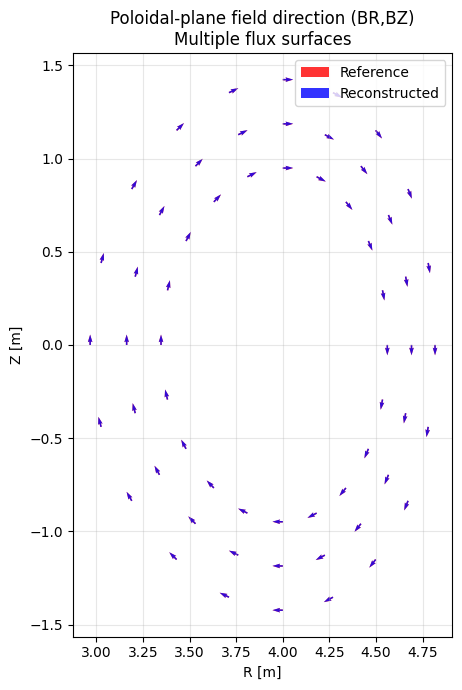

In [ ]:
# ------------------------------------------------------------
# Plot: Poloidal-plane field direction (BR,BZ)
#       Multiple rho surfaces, rec vs ref
# ------------------------------------------------------------
rhos = [0.6, 0.75, 0.9]
n_theta = 80
theta = np.linspace(0, 2*np.pi, n_theta, endpoint=False)

fig, ax = plt.subplots(figsize=(7, 7))

for rho in rhos:
    # --- DESC reference geometry and field ---
    grid = LinearGrid(rho=rho, theta=theta, zeta=0.0)
    data = eq.compute(["X", "Y", "Z", "B"], grid=grid, basis="xyz")

    X = data["X"]
    Y = data["Y"]
    Z = data["Z"]
    B_ref = data["B"]

    # --- NUFFT reconstructed field ---
    targets = np.stack([X, Y, Z], axis=1)
    targets_box = targets

    # --- NUFFT reconstructed plasma field ---
    bx, by, bz = eval_B(Bx_hat, By_hat, Bz_hat, jnp.array(targets_box), box)
    B_p = np.stack([bx, by, bz], axis=1)

    # --- coil field (direct) at same targets ---
    B_s = biot_savart_direct(jnp.array(targets), X_s, Y_s, Z_s, Jx_s, Jy_s, Jz_s, w_s)

    # total reconstructed
    B_rec = B_p + B_s

    # --- Cylindrical coordinates ---
    R = np.sqrt(X**2 + Y**2)
    phi = np.arctan2(Y, X)
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)

    # Reference (BR,BZ)
    BR_ref = B_ref[:, 0]*cosphi + B_ref[:, 1]*sinphi
    BZ_ref = B_ref[:, 2]

    # Reconstructed (BR,BZ)
    BR_rec = B_rec[:, 0]*cosphi + B_rec[:, 1]*sinphi
    BZ_rec = B_rec[:, 2]

    # --- Normalize for direction-only arrows ---
    def normalize(u, v, eps=1e-14):
        m = np.sqrt(u*u + v*v) + eps
        return u/m, v/m

    u_ref, v_ref = normalize(BR_ref, BZ_ref)
    u_rec, v_rec = normalize(BR_rec, BZ_rec)

    # Downsample arrows for clarity
    step = max(1, n_theta // 20)
    idx = np.arange(0, n_theta, step)

    # --- Plot ---
    ax.quiver(
        R[idx], Z[idx],
        u_ref[idx], v_ref[idx],
        color="red",
        angles="xy",
        scale_units="xy",
        scale=18,
        width=0.004,
        alpha=0.8,
        label="Reference" if rho == rhos[0] else None,
    )

    ax.quiver(
        R[idx], Z[idx],
        u_rec[idx], v_rec[idx],
        color="blue",
        angles="xy",
        scale_units="xy",
        scale=18,
        width=0.004,
        alpha=0.8,
        label="Reconstructed" if rho == rhos[0] else None,
    )

ax.set_aspect("equal")
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")
ax.set_title("Poloidal-plane field direction (BR,BZ)\nMultiple flux surfaces")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()
